# Predicting Future Sales
This notebook will serve as the main hub for the Kaggle competition of predicting future sales, which can be found here:
https://www.kaggle.com/c/competitive-data-science-predict-future-sales. All datasets and instructions can also be found on the competition website link. This project will aim to use the existing data to predict future sales using optimal machine learning strategies. Skills to be practiced involve everything from visualization to communication with different audiences to machine learning algorithms.

## Introduction
The project will be broken up into several parts, as I will be working on this each week for several weeks whilst following along the respective Coursera course (https://www.coursera.org/learn/competitive-data-science/). Thus, the project (like most projects anyway) will not be completed in one go, but it will be a complete piece of work for the end reader. In the end, this project can serve as a guideline for not only future data science competition frameworks, but real life examples, datasets, and problems as well. I am especially looking forward to using this dataset because the data provided is in Russian, so outside of numbers we cannot provide much domain intuition. This is perfect for data science practice, and perfect for anyone reading as well, because we all start on the same page (unless you can read Russian!).

## Set up and "Pre-Process"
We can start by getting all of our modules in place, and loading our datasets in. Pre-process is in quotes because we will just be looking at some preliminary things in our loaded data at first like data types. We will continue with EDA which will cover most of the pre-process steps afterwards, and given the nature of competition data, there is less to pre-process at first anyway compared to "real life" data.

In [67]:
# ignore some harmless warnings
import warnings
warnings.filterwarnings('ignore')

# classic analysis modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

# never forget
%matplotlib inline

# ML modules tested
import lightgbm as lgb
# from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# enhances our experience
# import tensorflow as tf
# import keras
import pickle
import gc

In [2]:
# load in datasets
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
item_cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv.gz')
sample_sub = pd.read_csv('sample_submission.csv.gz')
test = pd.read_csv('test.csv.gz')

In [3]:
# take a look at data types
print(items.dtypes, "\n")
print(shops.dtypes, "\n")
print(item_cats.dtypes, "\n")
print(train.dtypes, "\n")
print(sample_sub.dtypes, "\n")
print(test.dtypes, "\n")

item_name           object
item_id              int64
item_category_id     int64
dtype: object 

shop_name    object
shop_id       int64
dtype: object 

item_category_name    object
item_category_id       int64
dtype: object 

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object 

ID                  int64
item_cnt_month    float64
dtype: object 

ID         int64
shop_id    int64
item_id    int64
dtype: object 



Given only data types of the respective datasets, nothing really jumps out right away at us, although it never hurts to look for abnormal types. Even though this was just the 'set-up', we laid the basic foundation of our project down and can really get started now. We can begin to take note of certain columns that we may want to classify as numerical or categorical for now, and we'll work more on this next in the EDA part of the project. 

## EDA - Exploratory Data Analysis
Now we will begin EDA - which is just a fancy term and explanation of getting all of our data ready for our baseline machine learning model later on. We will do things like get familiar with the data, generate and aggregate features if necessary, and drop features that we deem unimportant. We will also look at what the numerical features represent, if there are any outliers, and if they need to be regularized. EDA is the most important part of the project, even more so than the ML part in my opinion!

In [4]:
# lets take a look at each table first
# describes the items it looks like
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
# another description table about the items
print(item_cats.shape)
item_cats.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
# ids and names for the shops
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
# an example of what our submission should ultimately look like
print(sample_sub.shape)
sample_sub.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [8]:
# our training set
print(train.shape)
train.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
# our test set
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [10]:
# lets see what we're training
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


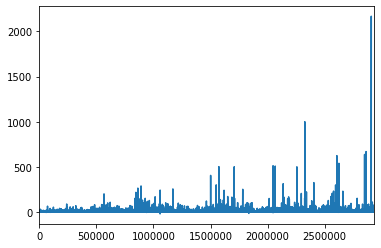

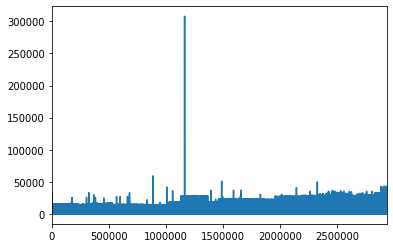

In [11]:
# the max values of item_price and item_cnt_day look odd
train['item_cnt_day'].plot()
plt.show()
train['item_price'].plot()
plt.show()

Wow! It would probably be best to remove these outliers from the training set - they will certainly not help us.

In [12]:
# remove outliers
train = train[train['item_price'] < 100000]
train = train[train['item_cnt_day'] < 1000]

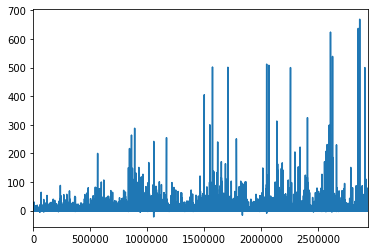

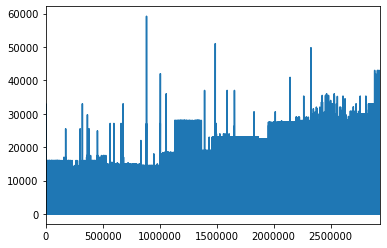

In [13]:
# much better
train['item_cnt_day'].plot()
plt.show()
train['item_price'].plot()
plt.show()

It looks like we are trying to predict item_cnt_month, so let's explore that further now by starting with looking at number of items per category.

In [14]:
# get value counts for items per cat
items_per_cat = items.item_category_id.value_counts().iloc[:10]
items_per_cat = items_per_cat.sort_index(sort_remaining=True)

Text(0.5, 1.0, 'Number of items per category')

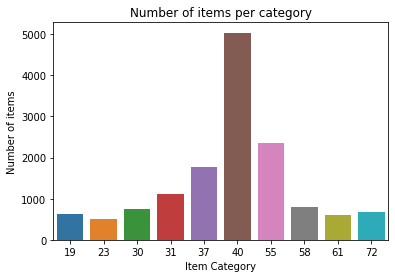

In [15]:
# plot - sns is beautiful
sns.barplot(items_per_cat.index, items_per_cat.values)
plt.xlabel("Item Category")
plt.ylabel("Number of items")
plt.title("Number of items per category")

Category 40 is extremely popular! We don't really need to know what it is (everything is in Russian), but for those interested it's some sort of DVD.

In [16]:
item_cats.iloc[40]

item_category_name    Кино - DVD
item_category_id              40
Name: 40, dtype: object

We now have the most "popular" items by category, so let's try and do the same thing with shops. Which are the most popular shops?

In [17]:
# aggregate items by shop
popular_shops = train.groupby('shop_id')['item_cnt_day'].sum()
popular_shops = popular_shops.sort_values(ascending=False)[:10]

Text(0.5, 1.0, 'Popular shops')

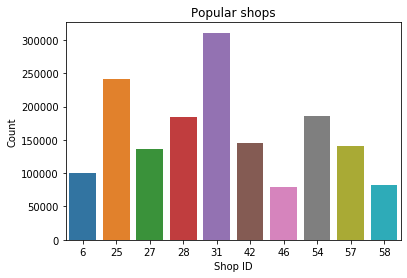

In [18]:
# plot again
sns.barplot(popular_shops.index, popular_shops.values)
plt.xlabel("Shop ID")
plt.ylabel("Count")
plt.title("Popular shops")

The total number of items sold are pretty distributed, but shop #31 is the clear cut winner here. Now, let's break item categories down even further into item ids themselves:

In [19]:
# aggegate items by id
popular_items = train.groupby('item_id')['item_cnt_day'].sum()
popular_items = popular_items.sort_values(ascending=False)[:10]

Text(0.5, 1.0, 'Popular items')

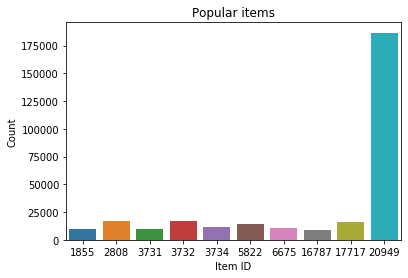

In [58]:
# plot again
sns.barplot(popular_items.index, popular_items.values)
plt.xlabel("Item ID")
plt.ylabel("Count")
plt.title("Popular items")

Item #20949 sold more than 5x than 2nd place! We should really pay attention to this moving forward. And just in case anyone is curious - no I cannot tell what the item is without going on Google translate...

In [21]:
items.iloc[20949]

item_name           Фирменный пакет майка 1С Интерес белый (34*42)...
item_id                                                         20949
item_category_id                                                   71
Name: 20949, dtype: object

OK, now that we have a rough idea of which items, categories, and shops are most popular, we can plot the bigger picture: let's see the number of items sold each month in our training set.

In [22]:
# aggregate again by month
item_cnt_month = train.groupby('date_block_num')['item_cnt_day'].sum()

Text(0.5, 1.0, 'Number of items sold in each month')

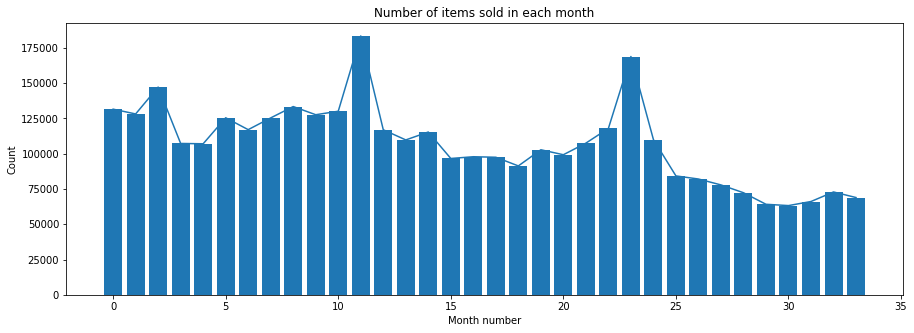

In [55]:
# plot again
plt.figure(figsize=(15,5))
plt.bar(item_cnt_month.index, item_cnt_month.values)
plt.plot(item_cnt_month.index, item_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Number of items sold in each month")

There are a couple of peaks to tke note of, but the more intersting trend to me is that the number of items sold per month in total is trending down. This company might be in trouble! However, items sold =/= revenue. What if they sold 1 item for a trillion dollars? Time to look at price:

In [24]:
# aggregate again but for price
price_cnt_month = train.groupby('date_block_num')['item_price'].sum()

Text(0.5, 1.0, 'Total price of items sold in each month')

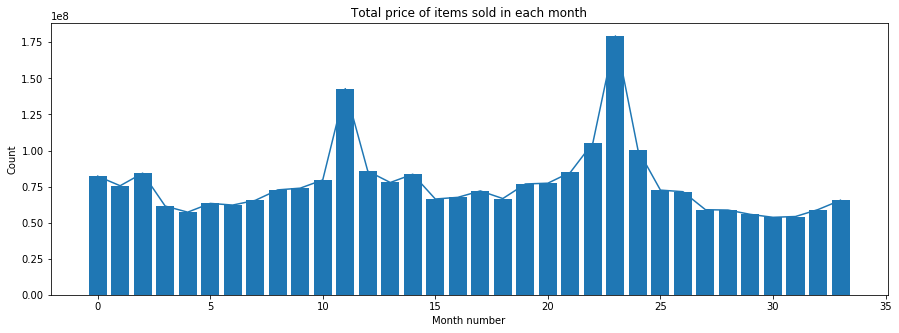

In [54]:
# plot again
plt.figure(figsize=(15,5))
plt.bar(price_cnt_month.index, price_cnt_month.values)
plt.plot(price_cnt_month.index, price_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Total price of items sold in each month")

In [26]:
# is there a correlation? - yes - .732
np.corrcoef(item_cnt_month.values, price_cnt_month.values)

array([[1.        , 0.73233703],
       [0.73233703, 1.        ]])

Given the total price of items sold, the decline doesn't seem AS bad, but it is still trending down. It looks the company may be in trouble after all - and the correlation more or less tells us this. We are not here to see how we can increase sales though, remember! We are here to predict sales going forward; to determine if this is indeed going to be a problem. We have done what we can with the features that we have to get some insight. The next step is to do some pre-processing and feature engineering to see if we can optimize our features for our model.

## EDA - Engineering Features
Some things to note and a guideline for this part of the EDA:
* we are trying to predict sales for the 34th month it seems like - date block num 34 given 1-33
* our test set only has a couple columns - we can populate this with information and features from our groupings in the first part of EDA
* we can create new features by grouping together shop, item, and month
* since this appears to be a good time series dataset - we can create some features using lag data from previous months 
* our final training set from all of these should be a new df separate from the original csv, with all relevant features included (new features, groupigs, mean encoding, etc.). Double check if necessary, always!

Let's start by taking care of the 34th month block where applicable:

In [27]:
# add block 34
block = train['date_block_num'].max() + 1
test['date_block_num'] = block
test = test.drop(columns=['ID'])
test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [28]:
# then we can create a grid from all shops/items combinations from that month as seen in the course videos
# create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# for every month...
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)
grid = pd.concat([grid, test])
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [29]:
# next we create features by grouping shops, items and month using grid to get all_data
# groupby data to get shop-item-month aggregates
gb = train.groupby(index_cols, as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target'})
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# shop-month aggregates
gb = train.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# item-month aggregates
gb = train.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_item'})
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# save memory
del grid, gb 
gc.collect()
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0


In [30]:
# lag features! create features using previous months data
# first get columns that we will use
cols_to_rename = list(all_data.columns.difference(index_cols))
shift_range = [1, 2, 3, 4, 5, 12]

# then 'make the lag'
for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
del train_shift
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
0,59,22154,0,1.0,2017.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,2017.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,2017.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,2017.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# finally...we will add "item category id" as a feature and drop irrelevant columns
# don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12]

# list of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]

# we will drop these at fitting stage
to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']

# category for each item
item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')

gc.collect()

41

In [32]:
# sanity check
to_drop_cols

['target', 'target_shop', 'target_item', 'date_block_num']

In [33]:
# and lastly, one final check...
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,...,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


I think we touched on almost if not all of our bullet points to conclude the EDA portion of the project. We now have a very nice datset to train on that is much better than our original "train" dataset. In the future, perhaps we could touch on other things such as mean encoding a lot more since it would make sense with this project especially, but this is just a baseline after all. I feel pretty comfortable moving forward and seeing what results we can get from this new dataset, so let's get started! We'll first have to split our new all_data into separate train and test folds.

## Train/Test Splits and Clipping
Let's split it based on time - test set should be AFTER the train set.

In [34]:
# date filter
dates = all_data['date_block_num']

# split it
dates_train  = dates[dates < block]
dates_test  = dates[dates == block]

In [35]:
# then split based on filter for X...
X_train = all_data.loc[dates <  block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == block].drop(to_drop_cols, axis=1)

# ...and y
y_train = all_data.loc[dates <  block, 'target'].values
y_test =  all_data.loc[dates == block, 'target'].values

In [36]:
# sanity check :)
X_train.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,...,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


In [37]:
# clip as per instruction suggestions
target_range = [0, 20]
target_range

[0, 20]

Now time for the moment we've all been waiting for...

## Modeling! And Hyperparameter Tuning
Now we will fit a couple of different models together to see how they do separately. I will be doing some hyperparameter tuning as well, simply adjusting some numbers here and there in each of the models to see if I can get better results. Another way to do this is to set a range of values for hyperparameters that you want to try, and then brute force all models to select the best ones. 

I don't think this is necessary at this point, but for future reference, it probably is the way to go - it just takes a bit of computational power. The parameters that I adjust will be clearly labeled in dictionaries and easily adjusted for readers as well, so both methods are plausible. For our models themselves, let's try simple linear regression first, and then LightGBM!

In [59]:
# linear regression - no params really...
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values).clip(*target_range)

In [60]:
# first submission file! - No pickle save necessary, this was pretty quick
submission = pd.DataFrame({'ID': sample_sub.ID, 'item_cnt_month': pred_lr})
submission.to_csv('predictions/submission_lr.csv', index=False)

In [40]:
# take a look
submission.head()

,ID,item_cnt_month
0,0,0.634966
1,1,0.098869
2,2,0.998720
3,3,0.213586
4,4,0.114366


In [62]:
# save model anyways if wanted
pkl = "models/lr.pkl"  
with open(pkl, 'wb') as file:
    pickle.dump(lr, file)

Our submission received the following: Your public and private LB scores are: 1.076689 and 1.064947.

This got a score of 5/10 on the Coursera assignment, which is expected. LR is nice, but it can be improved upon greatly.

Let's move forward.

In [41]:
# LightGBM
# can adjust these
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7,
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

# train standard here
model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test).clip(*target_range)

In [42]:
# save model
pkl = "models/lgb_classifier.pkl"  
with open(pkl, 'wb') as file:
    pickle.dump(model, file)

In [43]:
# second set of predictions
submission = pd.DataFrame({'ID': sample_sub.ID, 'item_cnt_month': pred_lgb})
submission.to_csv('predictions/submission_lgb.csv', index=False)

In [44]:
# take a look
submission.head()

,ID,item_cnt_month
0,0,0.461455
1,1,0.169606
2,2,0.826262
3,3,0.313241
4,4,1.917176


This time, our submission received the following: Your public and private LB scores are: 0.977171 and 0.975401.

This got a score of 8/10 on the Coursera assignment, which is good for a passing grade and unexpected! We are already done! But we can try one more thing to improve this model even further - ensembling.

Let's move forward :)

In [45]:
# concat to get meta-features - level 2
X_test_level2 = np.c_[pred_lr, pred_lgb]
X_test_level2

array([[0.63496579, 0.46145514],
       [0.09886923, 0.16960589],
       [0.99871993, 0.82626159],
       ...,
       [0.083599  , 0.04506413],
       [0.10706555, 0.04253993],
       [0.08856492, 0.04253993]])

In [46]:
# get y level 2
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# level 2 targets
y_train_level2 = y_train[dates_train.isin(dates_train_level2)]

## Validation - KFolds
Now we will use the KFold scheme associated with time series (as per the examples in course videos) to produce better level 2 train meta-features.

In [63]:
# init
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    print(cur_block_num)
 
    X_train_cur = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test_cur =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train_cur = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_cur =  all_data.loc[dates == cur_block_num, 'target'].values
    
    lr.fit(X_train_cur.values, y_train_cur)
    pred_lr = lr.predict(X_test_cur.values)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = pred_lr.clip(*target_range)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_cur, label=y_train_cur), 100)
    pred_lgb = model.predict(X_test_cur)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = pred_lgb.clip(*target_range)

27
28
29
30
31
32
33


## Ensembling
Now that we have 2 models...let's try our hand at ensembling. This is my first time ensembling ever so I looked at some examples provided on Kaggle for some help (no shame here! Get help wherever you can get it!) with this. It seems as though the equation I want is this:

a (lr_model) + (a - 1) (lgbm_model) 

where a is the alpha we need to figure out that best optimizes this new model. Unlike the last section where I did not brute force the parameter values, for this part, I will brute force through a range of alphas to determine which is best.

In [64]:
# try 1000 values
alphas = np.linspace(0, 1, 1001)

# average the models
scores = []
for alpha in alphas:
    mix = alpha * X_train_level2[:,0] + (1-alpha) * X_train_level2[:,1]
    scores.append(r2_score(y_train_level2, mix))

# convert
scores = np.array(scores)

# get best score
best_alpha = alphas[scores.argmax()]
r2_train_simple_mix = scores.max()

# and show!
print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.029000; Corresponding r2 score on train: 0.098060


In [65]:
# averaging ensemble
ensemble1 = best_alpha*X_test_level2[:,0] + (1-best_alpha)*X_test_level2[:,1]

# submission 3
submission = pd.DataFrame({'ID': sample_sub.ID, 'item_cnt_month': ensemble1})
submission.to_csv('predictions/submission_ensemble1.csv', index=False)

In [66]:
# save model
pkl = "models/ensemble_model.pkl"  
with open(pkl, 'wb') as file:
    pickle.dump(model, file)

This time, our submission received the following: Your public and private LB scores are: 0.973382 and 0.972418.

This got a score of 8/10 on the Coursera assignment, and this makes sense because while our scores did improve a little, it was not by much. While we did not improve our 8/10 to a 10/10 (although our score are already under 1.0, I figure the last 2 points are very very close - we could maybe try a different model from lr like xgboost and do the same ensembling to get even closer!), a score of around ~0.97 is still pretty good, and according to Kaggle leaderboards, would land us in around the top 25%. 

Ensembling helped a little bit to boost the score, especially since it was my first time trying out the method. In the future, it will probably be even easier to notice which techniques can be used where...

## Conclusion
In the end, our ensembling submission was overall the best of the 3, and this may be due to the few good parts about the lr model, but could also be variance and noise. Overall, this is expected in retrospect and honestly just a way to practice ensembling - averaging is good for 2 or more models that both have pros and cons, but LGBM was clearly the better model here - a weighted averaging of LGBM and LR would just heavily skew towards the former and we would end up with pretty much a LGBM model with a few LR nuances.

Like I stated above - the score can probably be increased just a bit more with models like xgboost instead of lr, and brute forcing our way through hyperparameters instead of playing around with what we have 1 by 1. I am happy with the score that we received for our first complex model/contest though; we have to remember that 0.97 as a score is not bad - an decrease of 0.2 puts us well into first place.

All in all, in this project we did 3 main things:
* EDA on exploring features
* Feature Engineering
* Modeling techniques such as Validation and Ensembling

This all led to a final model that predicted future sales for a company whose data was in a langauge we didn't even know! It goes to show how powerful machine learning techniques and analysis can be for all types of questions. In the future (because admittedly, there is no incentive to continue right now...), I hope to come back and do a few things:
* Improve score by getting to at least < 0.900
* Practice finding the best model through grid search using xgboost and higher leve frameworks (Tensorflow, Keras, etc.)
* Practice different ensembling methods such as stacking

Points 2 and 3 obviously lend to 1, and I have a feeling it will be much easier than this initial walkthrough with experience under our belt (it honestly just seems like a few changes). I am very satisfied with the results thus far and more importantly, very satisfied with the content that I have learned. Until next time!